# Social Network Analysis

### Libraries

In [1]:
# import libraries

import pandas as pd
import matplotlib.pyplot as plt
import json
import networkx as nx
from networkx.algorithms.community import girvan_newman
import community.community_louvain as louvain

In [2]:
# major variables

city = 'Sicklerville'

### Helper methods

In [3]:
def generate_graph(nodes, edges):
    '''
    Generate a networkx graph from nodes and edges dataframes
    '''
    G = nx.Graph()
    for _, row in nodes.iterrows():
        G.add_node(row['id'], name=row['name'])
    for _, row in edges.iterrows():
        G.add_edge(row['from'], row['to'], weight=row['weight'], type=row['type'])
    return G

In [4]:
def generate_communities(G, algorithm='girvan_newman'):
    '''
    Generate communities using the specified algorithm
    '''
    if algorithm == 'girvan_newman':
        communities = girvan_newman(G)
        first_iteration_communities = next(communities)
        return first_iteration_communities
    elif algorithm == 'louvain':
        communities = louvain.best_partition(G)
        return communities
    else:
        raise ValueError("Invalid algorithm. Choose 'girvan_newman' or 'louvain'.")

In [5]:
def visualize_graph(G, communities, city, connection):
    '''
    Visualize the graph with nodes colored by community
    '''
    plt.figure(figsize=(12, 5))
    pos = nx.spring_layout(G)
    
    community_colors = {}
    if isinstance(communities, tuple):
        for i, comm_nodes in enumerate(communities):
            for node in comm_nodes:
                community_colors[node] = i
    elif isinstance(communities, dict):
        for node, community_id in communities.items():
            community_colors[node] = community_id
    node_colors = [community_colors[node] for node in G.nodes()]
    
    nx.draw(G, pos,
            node_color=node_colors,
            cmap=plt.cm.tab20,
            node_size=20,
            edge_color='black',
            edgecolors='black',
            width=1,
            with_labels=False)
    
    plt.title(f"{city} - {connection}")
    plt.show()

In [6]:
def store_communities(communities, num_communities=None, filename='communities.json'):
    '''
    Store communities in a JSON file
    '''
    community_data = {"num_communities": num_communities, "communities": []}
    if isinstance(communities, tuple):
        for community_set in communities:
            community_data["communities"].append(list(community_set))
    elif isinstance(communities, dict):
        data = {}
        for node, community_id in communities.items():
            if community_id not in data:
                data[community_id] = []
            data[community_id].append(node)
        for _, nodes in sorted(data.items()):
            community_data["communities"].append(nodes)
    
    else:
        raise ValueError("Unsupported community format. Please provide a tuple of sets or a dictionary.")
    if num_communities is None:
        community_data["num_communities"] = len(community_data["communities"])
    
    with open(filename, 'w') as f:
        json.dump(community_data, f, indent=4)
    print(f"Communities have been stored in {filename}.")

### Friendship connections

In [7]:
# load friendship data

connection = 'friendships'

nodes = pd.read_csv(f'nodes_and_edges/{city}_{connection}_nodes.csv')
edges = pd.read_csv(f'nodes_and_edges/{city}_{connection}_edges.csv')

In [8]:
# generate friendship graph

friendship_graph = generate_graph(nodes, edges)

In [9]:
# generate friendship communities

friendship_communities = generate_communities(friendship_graph, algorithm='girvan_newman')
num_communities = len(friendship_communities)

store_communities(friendship_communities, num_communities, filename=f'communities/{city}_{connection}_communities.json')

Communities have been stored in communities/Sicklerville_friendships_communities.json.


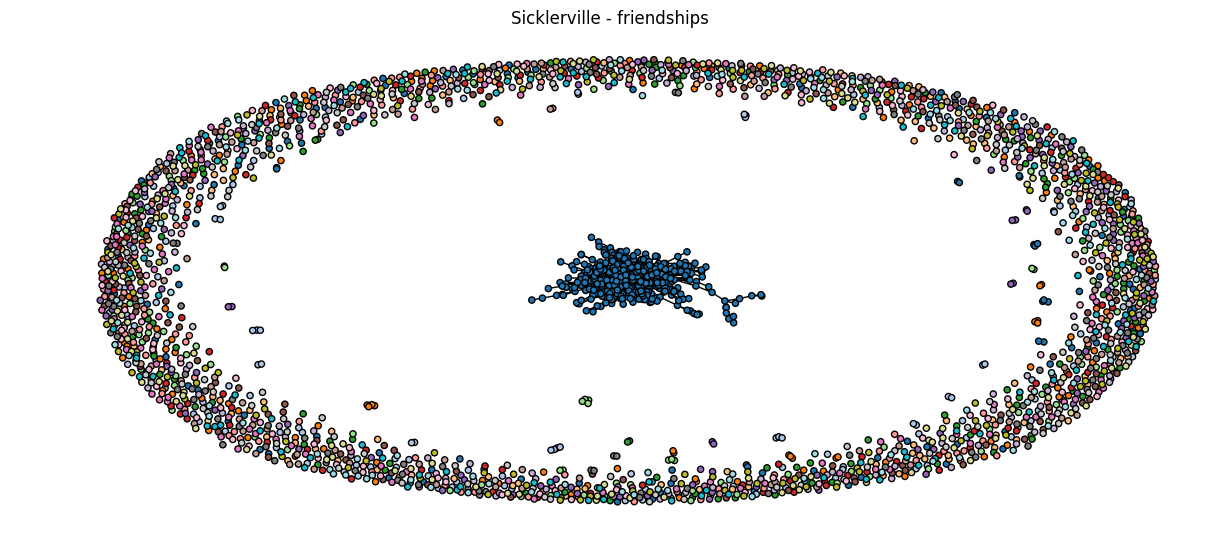

In [10]:
# visualize friendship graph

visualize_graph(friendship_graph, friendship_communities, city, connection)

### Review connections

In [11]:
# load review data

connection = 'business_reviews'

nodes = pd.read_csv(f'nodes_and_edges/{city}_{connection}_nodes.csv')
edges = pd.read_csv(f'nodes_and_edges/{city}_{connection}_edges.csv')

In [12]:
# generate review graph

review_graph = generate_graph(nodes, edges)

In [13]:
# generate review communities

review_communities = generate_communities(review_graph, algorithm='louvain') # girvan_newman is incredibly slow here
num_communities = len(set(review_communities.values()))

store_communities(review_communities, num_communities, filename=f'communities/{city}_{connection}_communities.json')

Communities have been stored in communities/Sicklerville_business_reviews_communities.json.


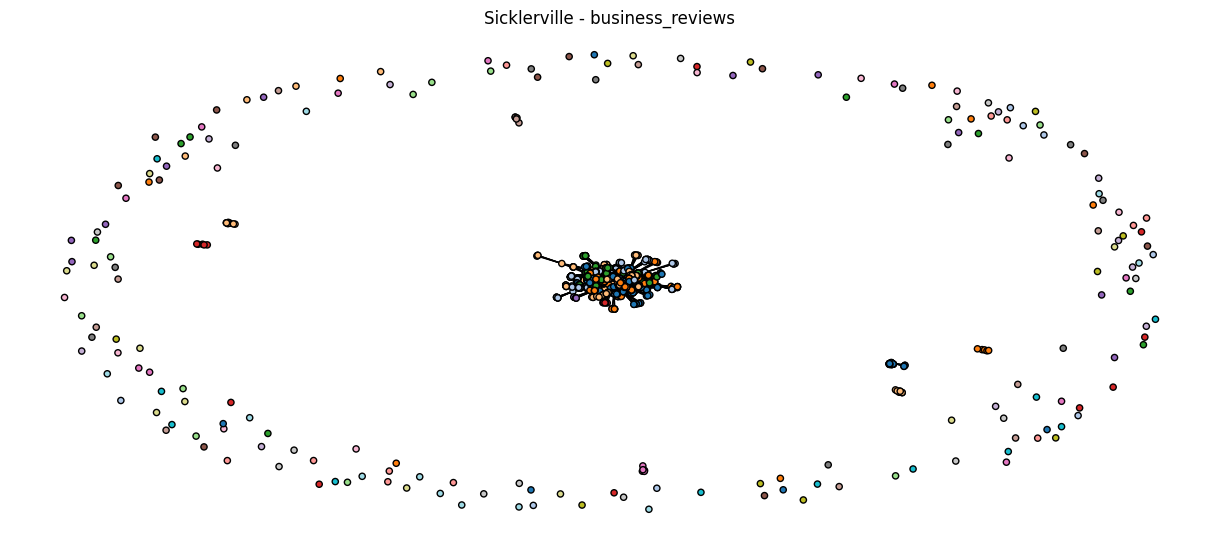

In [14]:
# visualize review graph

visualize_graph(review_graph, review_communities, city, connection)

### Tip connections

In [15]:
# load tip data

connection = 'business_tips'

nodes = pd.read_csv(f'nodes_and_edges/{city}_{connection}_nodes.csv')
edges = pd.read_csv(f'nodes_and_edges/{city}_{connection}_edges.csv')

In [16]:
# generate tip graph

tip_graph = generate_graph(nodes, edges)

In [17]:
# generate tip communities

tip_communities = generate_communities(tip_graph, algorithm='girvan_newman')
num_communities = len(tip_communities)

store_communities(tip_communities, num_communities, filename=f'communities/{city}_{connection}_communities.json')

Communities have been stored in communities/Sicklerville_business_tips_communities.json.


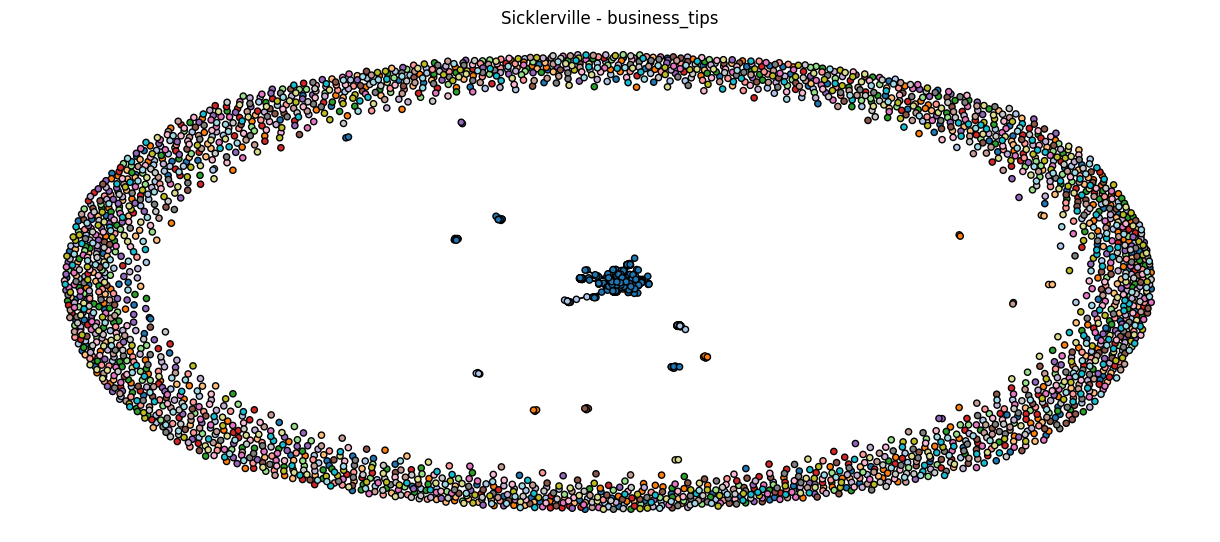

In [18]:
# visualize tip graph

visualize_graph(tip_graph, tip_communities, city, connection)

### Category connections

In [19]:
# load category data

connection = 'categories'

nodes = pd.read_csv(f'nodes_and_edges/{city}_{connection}_nodes.csv')
edges = pd.read_csv(f'nodes_and_edges/{city}_{connection}_edges.csv')

In [20]:
# generate category graph

category_graph = generate_graph(nodes, edges)

In [21]:
# generate category communities

category_communities = generate_communities(category_graph, algorithm='louvain')
num_communities = len(set(category_communities.values()))

store_communities(category_communities, num_communities, filename=f'communities/{city}_{connection}_communities.json')

Communities have been stored in communities/Sicklerville_categories_communities.json.


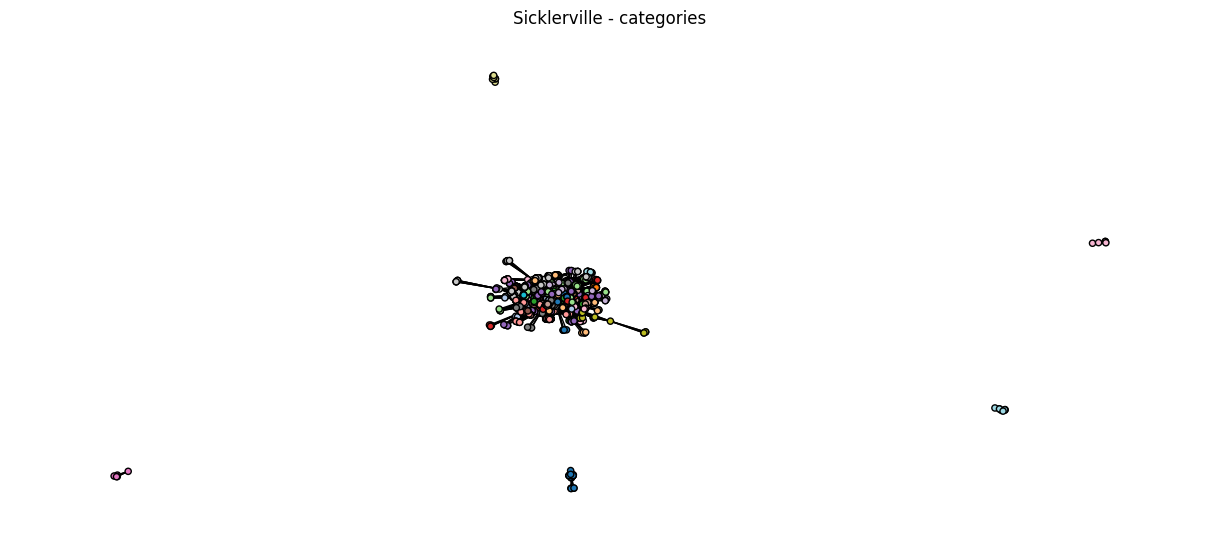

In [22]:
# visualize category graph

visualize_graph(category_graph, category_communities, city, connection)

### Category connections (with threshold)

In [23]:
# load threshold category data

connection = 'threshold_categories'

nodes = pd.read_csv(f'nodes_and_edges/{city}_{connection}_nodes.csv')
edges = pd.read_csv(f'nodes_and_edges/{city}_{connection}_edges.csv')

In [24]:
# generate threshold category graph

threshold_category_graph = generate_graph(nodes, edges)

In [29]:
# generate threshold category communities

threshold_category_communities = generate_communities(threshold_category_graph, algorithm='girvan_newman')
num_communities = len(threshold_category_communities)

store_communities(threshold_category_communities, num_communities, filename=f'communities/{city}_{connection}_communities.json')

Communities have been stored in communities/Sicklerville_threshold_categories_communities.json.


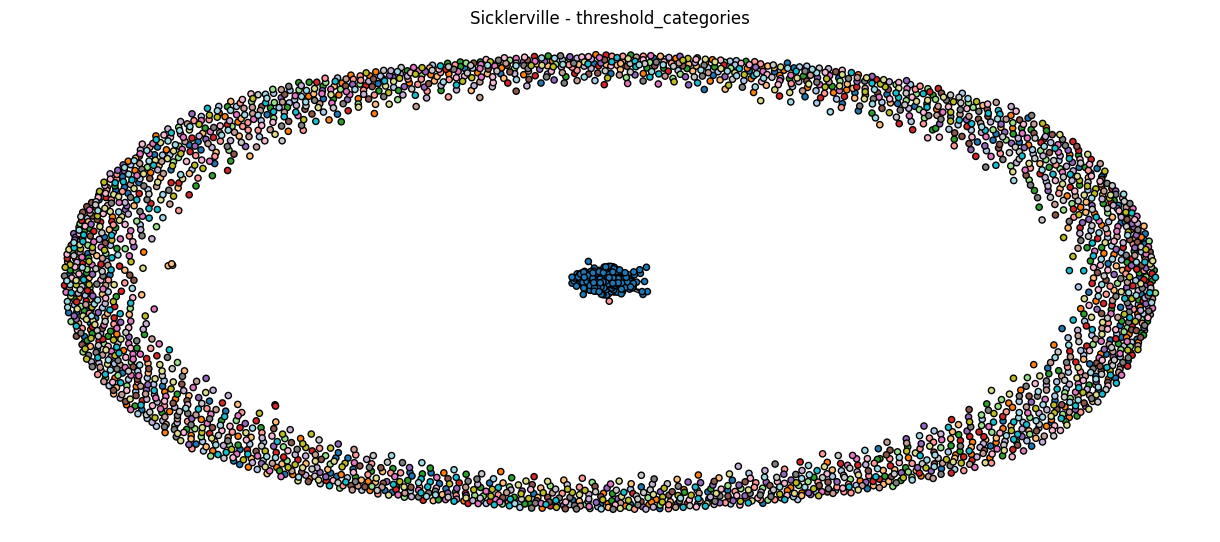

In [30]:
# visualize threshold category graph

visualize_graph(threshold_category_graph, threshold_category_communities, city, connection)

### Combined connections

In [31]:
# load combined data

connection = 'combined'

nodes = pd.read_csv(f'nodes_and_edges/{city}_{connection}_nodes.csv')
edges = pd.read_csv(f'nodes_and_edges/{city}_{connection}_edges.csv')

In [32]:
# generate combined graph

combined_graph = generate_graph(nodes, edges)

In [33]:
# generate combined communities

combined_communities = generate_communities(combined_graph, algorithm='louvain')
num_communities = len(set(combined_communities.values()))

store_communities(combined_communities, num_communities, filename=f'communities/{city}_{connection}_communities.json')

Communities have been stored in communities/Sicklerville_combined_communities.json.


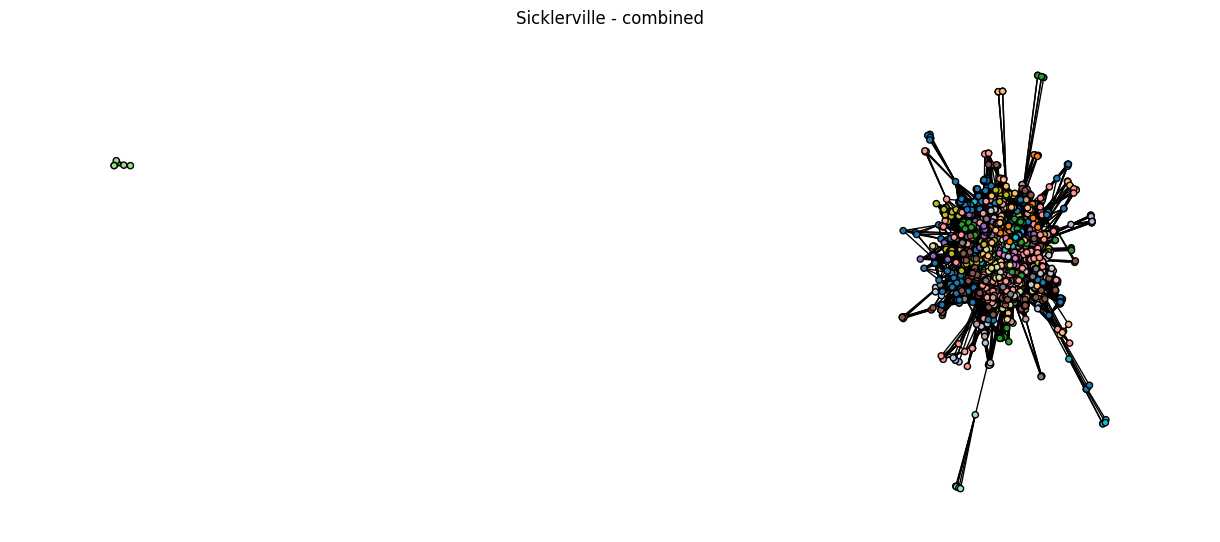

In [34]:
# visualize combined graph

visualize_graph(combined_graph, combined_communities, city, connection)

### Category and business review connections

In [35]:
# load category and review data

connection = 'categories_and_reviews'

nodes = pd.read_csv(f'nodes_and_edges/{city}_{connection}_nodes.csv')
edges = pd.read_csv(f'nodes_and_edges/{city}_{connection}_edges.csv')

In [36]:
# generate category and review graph

category_and_review_graph = generate_graph(nodes, edges)

In [40]:
# generate category and review communities

category_and_review_communities = generate_communities(category_and_review_graph, algorithm='louvain')
num_communities = len(set(category_and_review_communities.values()))

store_communities(category_and_review_communities, num_communities, filename=f'communities/{city}_{connection}_communities.json')

Communities have been stored in communities/Sicklerville_categories_and_reviews_communities.json.


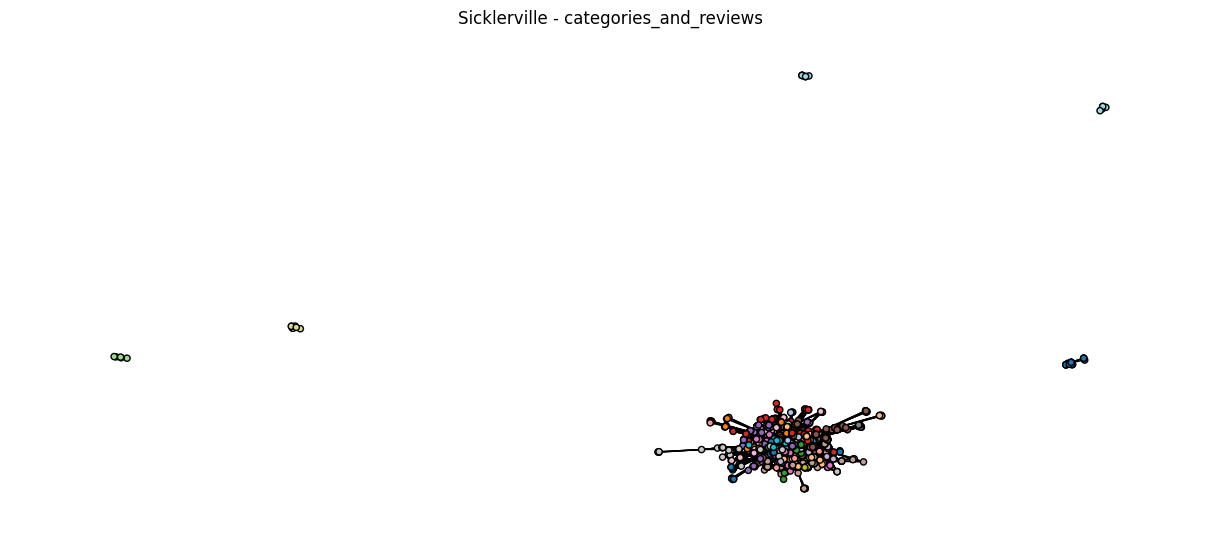

In [41]:
# visualize combined graph

visualize_graph(category_and_review_graph, category_and_review_communities, city, connection)

### Graph statistics

In [44]:
def calculate_density(graph):
    return nx.density(graph)

density_category_graph = calculate_density(category_graph)
density_combined_graph = calculate_density(combined_graph)
density_category_and_review_graph = calculate_density(category_and_review_graph)

print(f"Density of category graph: {density_category_graph:0.4f}")
print(f"Density of combined graph: {density_combined_graph:0.4f}")
print(f"Density of category and review graph: {density_category_and_review_graph:0.4f}")


Density of Category Graph: 0.0367
Density of Combined Graph: 0.0371
Density of Category and Review Graph: 0.0367


In [ ]:
# graphs diameter

def calculate_average_diameter(graph):
    if nx.is_connected(graph):
        diameter_weighted = nx.diameter(graph, weight='weight')
        print(f"Weighted undirected diameter: {diameter_weighted}")
    else:
        components = nx.connected_components(graph)
        diameters = []
        for i, component in enumerate(components, start=1):
            subgraph = graph.subgraph(component)
            diameter = nx.diameter(subgraph, weight='weight')
            diameters.append(diameter)
        
        average_diameter = sum(diameters) / len(diameters)
        print(f"\nAverage diameter of connected components: {average_diameter}")

print("For category graph:")
calculate_average_diameter(category_graph)

print("\nFor combined graph:")
calculate_average_diameter(combined_graph)

print("\nFor category and review graph:")
calculate_average_diameter(category_and_review_graph)

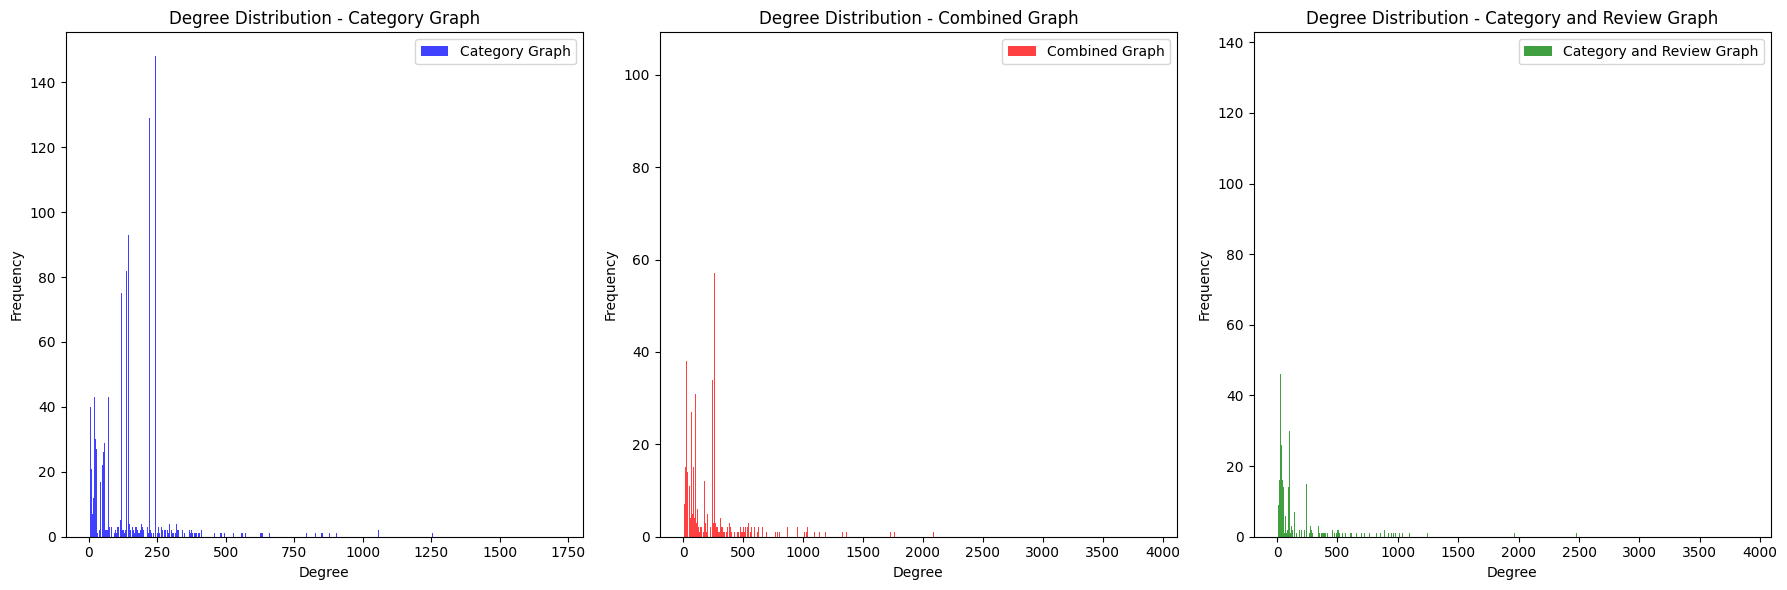

In [50]:
# graph degree distribution

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

def plot_degree_distribution(graph, ax, title, color):
    degrees = dict(nx.degree(graph, weight='weight'))
    ax.hist(degrees.values(), bins=range(1, max(degrees.values()) + 2), alpha=0.75, label=title, color=color)
    ax.set_xlabel('Degree')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Degree Distribution - {title}')
    ax.legend()

plot_degree_distribution(category_graph, axes[0], "Category Graph", 'blue')
plot_degree_distribution(combined_graph, axes[1], "Combined Graph", 'red')
plot_degree_distribution(category_and_review_graph, axes[2], "Category and Review Graph", 'green')

plt.tight_layout()
plt.show()

In [ ]:
# closeness centrality

def compute_closeness(graph):
    if nx.is_weighted(graph):
        closeness = nx.closeness_centrality(graph, distance='weight')
    else:
        closeness = nx.closeness_centrality(graph)
    return closeness

category_closeness = compute_closeness(category_graph)
combined_closeness = compute_closeness(combined_graph)
category_and_review_closeness = compute_closeness(category_and_review_graph)

category_closeness_df = pd.DataFrame({'name': list(category_closeness.keys()), 'closeness': list(category_closeness.values())})
category_closeness_df = category_closeness_df.sort_values(by='closeness', ascending=False)

combined_closeness_df = pd.DataFrame({'name': list(combined_closeness.keys()), 'closeness': list(combined_closeness.values())})
combined_closeness_df = combined_closeness_df.sort_values(by='closeness', ascending=False)

category_and_review_closeness_df = pd.DataFrame({'name': list(category_and_review_closeness.keys()), 'closeness': list(category_and_review_closeness.values())})
category_and_review_closeness_df = category_and_review_closeness_df.sort_values(by='closeness', ascending=False)

print("Category graph closeness centrality:")
print(category_closeness_df)

print("\nCombined graph closeness centrality:")
print(combined_closeness_df)

print("\nCategory and review graph closeness centrality:")
print(category_and_review_closeness_df)

# taking too long to compute (when considering weights)

In [ ]:
# betweenness centrality

def compute_betweenness(graph):
    num_nodes = len(graph.nodes)
    k = min(500, num_nodes)
    
    betweenness = nx.betweenness_centrality(graph, k=k, weight='weight')
    betweenness_df = pd.DataFrame({'name': list(betweenness.keys()), 'betweenness': list(betweenness.values())})
    betweenness_df = betweenness_df.sort_values(by='betweenness', ascending=False)
    
    return betweenness_df

category_betweenness_df = compute_betweenness(category_graph)
combined_betweenness_df = compute_betweenness(combined_graph)
category_and_review_betweenness_df = compute_betweenness(category_and_review_graph)

print("Category graph betweenness centrality:")
print(category_betweenness_df)

print("\nCombined graph betweenness centrality:")
print(combined_betweenness_df)

print("\nCategory and review graph betweenness centrality:")
print(category_and_review_betweenness_df)

# running with a representative sample so it doesn't take forever

In [ ]:
# edge betweenness centrality

def compute_edge_betweenness(graph):
    num_edges = len(graph.edges)
    k = min(500, num_edges)
    
    edge_betweenness = nx.edge_betweenness_centrality(graph, k=k, weight='weight')
    
    return edge_betweenness

category_edge_betweenness = compute_edge_betweenness(category_graph)
combined_edge_betweenness = compute_edge_betweenness(combined_graph)
category_and_review_edge_betweenness = compute_edge_betweenness(category_and_review_graph)

print("Category graph edge betweenness centrality:")
print(category_edge_betweenness)

print("\nCombined graph edge betweenness centrality:")
print(combined_edge_betweenness)

print("\nCategory and review graph edge betweenness centrality:")
print(category_and_review_edge_betweenness)

# running with a representative sample so it doesn't take forever

In [ ]:
# average shortest path length

def compute_average_shortest_path_length(graph):
    if nx.is_connected(graph):
        return nx.average_shortest_path_length(graph, weight='weight')
    else:
        avg_lengths = []
        connected_components = nx.connected_components(graph)
        for component in connected_components:
            component_graph = graph.subgraph(component)
            avg_lengths.append(nx.average_shortest_path_length(component_graph, weight='weight'))
        return sum(avg_lengths) / len(avg_lengths)

print("Average shortest path length for category graph:")
print(compute_average_shortest_path_length(category_graph))

print("\nAverage shortest path length for combined graph:")
print(compute_average_shortest_path_length(combined_graph))

print("\nAverage shortest path length for category and review graph:")
print(compute_average_shortest_path_length(category_and_review_graph))

# taking too long to compute

In [55]:
# graph homophily

def compute_homophily(graph):
    return nx.degree_assortativity_coefficient(graph, weight='weight')

print("Homophily for category graph:")
print(f"All network = {compute_homophily(category_graph):.3f}")

print("\nHomophily for combined graph:")
print(f"All network = {compute_homophily(combined_graph):.3f}")

print("\nHomophily for category and review graph:")
print(f"All network = {compute_homophily(category_and_review_graph):.3f}")

Homophily for category graph:
All network = -0.004

Homophily for combined graph:
All network = -0.008

Homophily for category and review graph:
All network = -0.008
